In [1]:
# Load the Drive helper and mount
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Neighborhoods and living Community Recommendation Analysis in West Los Angeles Area

## Introduction: Description & Disscusion of the Background

West Los Angeles area is one of the most popular place in the US. This area contains well-known tuorist attractions, the most expensive real estates, the toppest education resources and friendly neighborhoods. It's a place that people love to live in and there are a lot of resturants and stores for people to hang out. To help locals and people who want to locate in this area make a good choice of living place and community, I would like to do a recommendation analysis based on the location data of different venues around this area from the Foursquare API.

The plan has several parts:

Part 1. Spatial clustering into groups

The capstone gathered the data by the neighbourhoods first. However, I did not use the same way. I simply collect the data by location coordinates first and use the spatial clustering method to group the location data points by the density. The method used here is DBSCAN (Density-based spatial clustering of applications with noise). It can sufficiently compress the information by the location density for further analysis on the venues gathering together.

Part 2. K-Means Clustering evaluating the similarities among the groups

Since the groups are built in the part 1, we could do a K-Means clustering on the aggreagted data by the data matrix after the one-hot encoding on the category. We need to select a meaningful value for K according to the within group standard error. Another thing I would like to do is to compare the result before and after PCA because the number of dimension is much larger than the number of observations. K-means does not perform very well when the dimension is too high when we use the euclidean distance. The final result could be used to give a general recommendation of locations that people could choose based on thier habits.

Part 3. working on

## Loading Packages

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

# !conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
from geopy.distance import vincenty # module used to calculate the distance

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

# !conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


## Connect foursquare API to access the geospatial raw data

The raw data is collected from the Foursquare API like what we did before for this capstone. I choose the area range: (34.073421, -118.465343), (34.036368, -118.465343), (34.073421, -118.337496), (34.036368, -118.337496). I equally select 100 (10 by 10) location coordinates in this area and send them to the API to explore the nearby venues with a radius equal to 500. The name, address, location coordinates and most importantly, the categories are all collected.

Because each center point among those 100 points is used to explore in a 500 radius, it is higly possible that there are many duplicated venues. Before cleaning duplicates, there are 2473 venues. After cleaning duplicates, there are 1623 unqiue venues in total. And there are 263 unqiue categories.



In [2]:
CLIENT_ID = 'RLGSBQG4IUCCFW42BJXRA2WG5SFJCF1F2O5IB50C3XIITQHW' # your Foursquare ID
CLIENT_SECRET = '3MIND2EJZV0MTUCGJHVS13YUZH0YVLGHPIH5ZI5HTZ2CF0IJ' # your Foursquare Secret
VERSION = '20190916'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: RLGSBQG4IUCCFW42BJXRA2WG5SFJCF1F2O5IB50C3XIITQHW
CLIENT_SECRET:3MIND2EJZV0MTUCGJHVS13YUZH0YVLGHPIH5ZI5HTZ2CF0IJ


In [0]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# Function used to dataframe cleaning
def dat_clean(lat, log, radius = 500, limit = 100):
  url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
    CLIENT_ID, CLIENT_SECRET, lat, log, VERSION, radius, limit)
  results = requests.get(url).json()
  items = results['response']['groups'][0]['items']
  dataframe = json_normalize(items) # flatten JSON
  # filter columns
  filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
  dataframe_filtered = dataframe.loc[:, filtered_columns]
  # filter the category for each row
  dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)
  # clean columns
  dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]
  return dataframe_filtered

In [4]:
lats = [34.073421, 34.036368]
logs = [-118.465343, -118.337496]
lat_seps = np.linspace(lats[0],lats[1],10)
log_seps = np.linspace(logs[0],logs[1],10)

dataframes = []
for lat in lat_seps:
  for log in log_seps:
    dataframes.append(dat_clean(lat,log))
    
print('Total number of Venues before removing duplicates:',sum([len(d) for d in dataframes]))

Total number of Venues before removing duplicates: 2504


In [5]:
# Combine and remove duplicates
dat = dataframes[0]
for i,d in enumerate(dataframes):
  if i > 0:
    dat = pd.concat([dat,d]).drop_duplicates(subset='id').reset_index(drop=True)

print('Total number of Venues after removing duplicates:',len(dat))
dat.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


Total number of Venues after removing duplicates: 1642


,address,categories,cc,city,country,crossStreet,distance,formattedAddress,id,isFuzzed,isServiceAreaBusiness,labeledLatLngs,lat,lng,name,neighborhood,postalCode,state
0,11461 W Sunset Blvd,Hotel,US,Los Angeles,United States,at Church Ln,312,"[11461 W Sunset Blvd (at Church Ln), Los Angel...",4a417892f964a52055a51fe3,NaN,NaN,"[{'label': 'display', 'lat': 34.07274274574856...",34.072743,-118.468628,Luxe Sunset Boulevard Hotel,NaN,90049,CA
1,170 N Church Ln,Hotel,US,Los Angeles,United States,Sunset Blvd,255,"[170 N Church Ln (Sunset Blvd), Los Angeles, C...",46a7d6e0f964a5204c491fe3,NaN,NaN,"[{'label': 'display', 'lat': 34.07358121181901...",34.073581,-118.468109,Hotel Angeleno,NaN,90049,CA
2,11650 Bellagio Rd,Historic Site,US,Los Angeles,United States,at Acanto St,418,"[11650 Bellagio Rd (at Acanto St), Los Angeles...",4fe6a02d77166281e24de0e4,NaN,NaN,"[{'label': 'display', 'lat': 34.07676219073070...",34.076762,-118.467420,The Enplug House,NaN,90049,CA
3,170 N Church Ln,New American Restaurant,US,Los Angeles,United States,Sunset Blvd,242,"[170 N Church Ln (Sunset Blvd), Los Angeles, C...",4bc3bb71dce4eee164ba719d,NaN,NaN,"[{'label': 'display', 'lat': 34.0735656641994,...",34.073566,-118.467967,West Restaurant & Lounge,NaN,90049,CA
4,San Diego Fwy,Intersection,US,Los Angeles,United States,at W Sunset Blvd.,134,"[San Diego Fwy (at W Sunset Blvd.), Los Angele...",4cadcad455238cfaaf92b4fb,NaN,NaN,"[{'label': 'display', 'lat': 34.07271083731946...",34.072711,-118.466520,I-405 / Sunset Blvd.,NaN,90049,CA


### Show the maps

Plot each venue on to the map by the location coordinates. Each venue is displayed as a blue point. The daker space means more points are closely gathering together on the map.

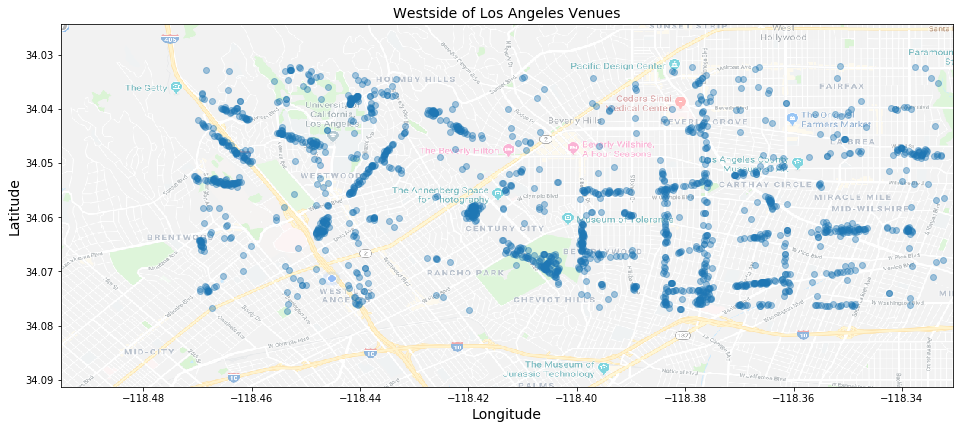

In [6]:
map_image = mpimg.imread('/content/drive/My Drive/Colab Notebooks/Coursera/IBM Data Science Capstone/map1.png')
#34.091303, -118.495294
#34.024301, -118.330490

plt.figure(figsize=(16, 10))
plt.scatter(x=dat.lng, y=dat.lat, alpha=0.4)
plt.imshow(map_image, extent=[-118.495294, -118.330490, 34.091303, 34.024301], alpha=0.5)
plt.title('Westside of Los Angeles Venues', fontsize=14)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.show()

## Data Cleaning and Preparation

After the raw data cleaning, duplicates are removed. There are 1623 venues remained. The next stage is to do further transformation of the data.

So each data point is a Venue location with a category. To have a better understanding of our dataset and extent the information, we would want to transform the original dataset into a high-dimensional data matrix by one-hot encoding.

There are 267 unqiue categories in total and many of them are very redundant. Here a cleaning and combining process is needed to make the categories more clear and reduce the dimension. After this process, there will be only 197 unqiue categories.

After the one-hot encoding, the category column is extended to 197 columns. The data matrix is very spatial that each raw having a lot of 0s and a single 1. We are going to do futher aggregation based on this dataset after the spatial clustering is done.

Total number of unqiue categories: 267


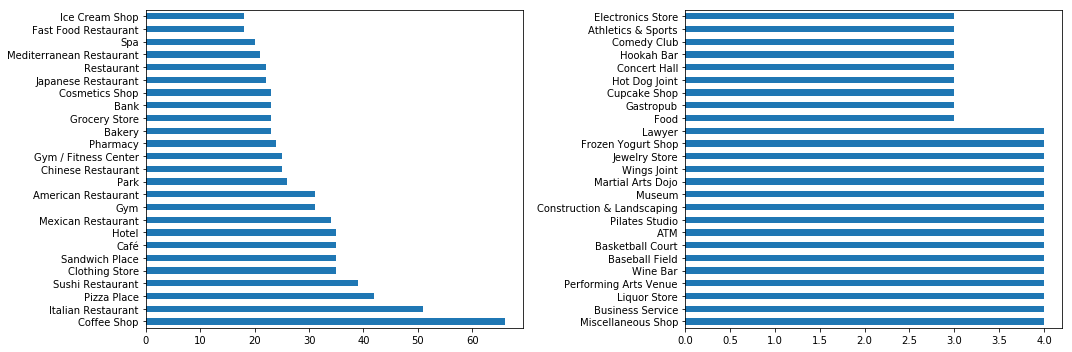

In [7]:
print('Total number of unqiue categories:',len(list(set(dat.categories))))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
dat.categories.value_counts()[:25].plot(kind='barh',ax=axes[0])
dat.categories.value_counts()[100:125].plot(kind='barh',ax=axes[1])
plt.tight_layout() 
plt.show()

The categories are too detailed, which cause the problem that many categories only have one Venue (observation). This would cause a lot of meaningless dimension for the clustering and also cause the information loss. We need to check the categories again and combine them a bit more.

Total Number of unqiue combined categories: 197


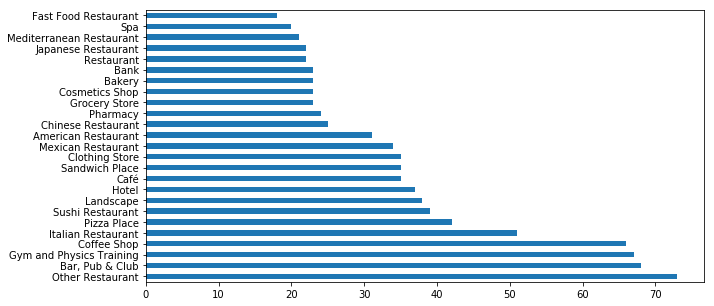

In [8]:
# Copy of the categories
categories_counts = dat.categories.value_counts()
categories = dat.categories.copy(deep=False)

# Combining redudant categories
for i in range(len(categories)):
  if 'Pub' in categories[i] or 'Bar' in categories[i] or 'Club' in categories[i] or 'Speakeasy' in categories[i]:
    categories[i] = 'Bar, Pub & Club'
  if 'Restaurant' in categories[i] and categories_counts[categories[i]] < 10:
    categories[i] = 'Other Restaurant'
  if 'Garden' in categories[i] or 'Park' in categories[i] or 'Landscaping' in categories[i]:
    categories[i] = 'Landscape'
  if 'School' in categories[i] or 'College' in categories[i]:
    categories[i] = 'Education'
  if 'Hotel' in categories[i] or 'Motel' in categories[i]:
    categories[i] = 'Hotel'
  if 'Gym' in categories[i] or 'Dance' in categories[i] or 'Recreation' in categories[i]:
    categories[i] = 'Gym and Physics Training'
    
# Plot the new top 25 categories
print('Total Number of unqiue combined categories:', len(categories.value_counts()))
plt.figure(figsize=(10,5))
categories.value_counts()[:25].plot(kind='barh')
plt.show()

In [9]:
# Add the new combined categories back to the dataset
dat['combined_categories'] = categories
dat.head(1)

,address,categories,cc,city,country,crossStreet,distance,formattedAddress,id,isFuzzed,isServiceAreaBusiness,labeledLatLngs,lat,lng,name,neighborhood,postalCode,state,combined_categories
0,11461 W Sunset Blvd,Hotel,US,Los Angeles,United States,at Church Ln,312,"[11461 W Sunset Blvd (at Church Ln), Los Angel...",4a417892f964a52055a51fe3,NaN,NaN,"[{'label': 'display', 'lat': 34.07274274574856...",34.072743,-118.468628,Luxe Sunset Boulevard Hotel,NaN,90049,CA,Hotel


### One-hot encoding for the original combined categories

In [10]:
# one hot encoding
dat_onehot = pd.get_dummies(dat[['combined_categories']], prefix="", prefix_sep="")

# add venue id column back to dataframe
dat_onehot['id'] = dat['id']
cols = list(dat_onehot.columns)
n_idx = cols.index('id')
cols[:n_idx] + cols[(n_idx+1):]

# move neighborhood column to the first column
fixed_columns = [cols[n_idx]] + cols[:n_idx] + cols[(n_idx+1):]
dat_onehot = dat_onehot[fixed_columns]
print(dat_onehot.shape)
dat_onehot.head(2)

(1642, 198)


,id,ATM,Accessories Store,Airport Terminal,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,"Bar, Pub & Club",Baseball Field,Basketball Court,Big Box Store,Bookstore,Boutique,Breakfast Spot,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Business Service,Cafeteria,Café,Camera Store,Candy Store,Car Wash,Cemetery,Chinese Restaurant,Chocolate Shop,Churrascaria,...,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,Roof Deck,Salad Place,Sandwich Place,Scenic Lookout,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,Spa,Spiritual Center,Sporting Goods Shop,Steakhouse,Storage Facility,Street Food Gathering,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tea Room,Tennis Court,Thai Restaurant,Theater,Toy / Game Store,Track,Video Game Store,Video Store,Warehouse Store,Watch Shop,Weight Loss Center,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,4a417892f964a52055a51fe3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,46a7d6e0f964a5204c491fe3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Part 1: spatial clustering into groups

### Compute DBSCAN

The scikit-learn DBSCAN haversine distance metric requires data in the form of [latitude, longitude] and both inputs and outputs are in units of radians.

1. eps is the physical distance from each point that forms its neighborhood

2. min_samples is the min cluster size, otherwise it's noise - set to 1 so we get no noise.

Extract the lat, lon columns into a numpy matrix of coordinates, then convert to radians when you call fit, for use by scikit-learn's haversine metric.

### First Clustering for the most densed data poinst

In [11]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

# represent points consistently as (lat, lng)
coords_ids = dat.id.values
coords = dat.as_matrix(columns=['lat', 'lng'])

# define the number of kilometers in one radian
kms_per_radian = 6371.0088

# define epsilon as 10 kilometers, converted to radians for use by haversine
epsilon = 0.2 / kms_per_radian

# Fit DBSCAN
db = DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
unique_labels = set(cluster_labels)

# get the number of clusters
num_clusters = len(set(cluster_labels))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

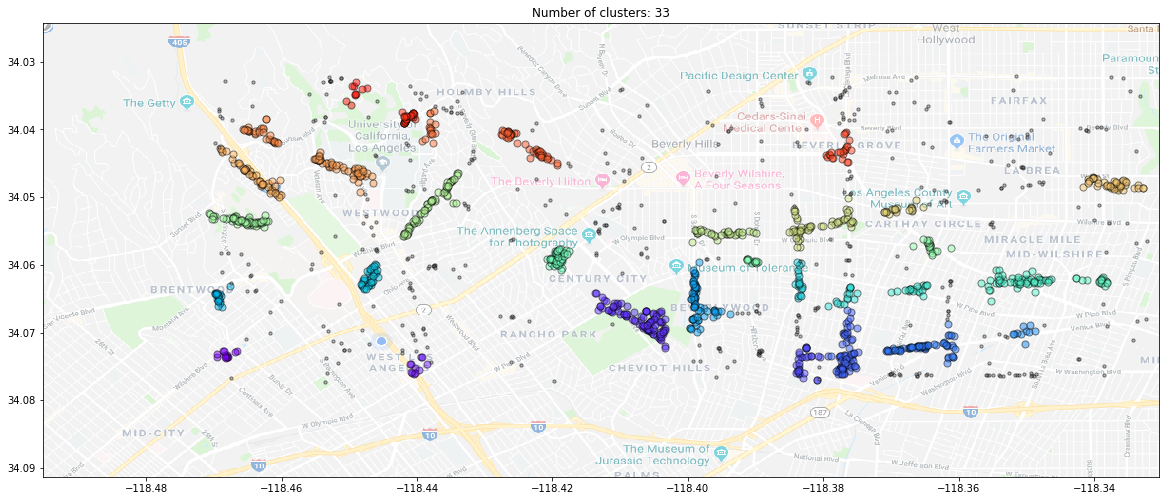

-------------------------------------
The number of noises: 437
-------------------------------------
Total number of Venues clustered: 1205
-------------------------------------
The number of Venues in Cluster 0 is 13
The number of Venues in Cluster 1 is 11
The number of Venues in Cluster 2 is 101
The number of Venues in Cluster 3 is 31
The number of Venues in Cluster 4 is 76
The number of Venues in Cluster 5 is 64
The number of Venues in Cluster 6 is 10
The number of Venues in Cluster 7 is 72
The number of Venues in Cluster 8 is 19
The number of Venues in Cluster 9 is 46
The number of Venues in Cluster 10 is 20
The number of Venues in Cluster 11 is 15
The number of Venues in Cluster 12 is 20
The number of Venues in Cluster 13 is 58
The number of Venues in Cluster 14 is 19
The number of Venues in Cluster 15 is 49
The number of Venues in Cluster 16 is 11
The number of Venues in Cluster 17 is 20
The number of Venues in Cluster 18 is 60
The number of Venues in Cluster 19 is 65
The number

In [12]:
# get colors and plot all the points, color-coded by cluster (or gray if not in any cluster, aka noise)
fig, ax = plt.subplots(figsize=(20, 10))
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

# for each cluster label and color, plot the cluster's points
for cluster_label, color in zip(unique_labels, colors):
    
    size = 50
    if cluster_label == -1: #make the noise (which is labeled -1) appear as smaller gray points
        color = 'gray'
        size = 10
    
    # plot the points that match the current cluster label
    x_coords = coords[cluster_labels==cluster_label][:,1]
    y_coords = coords[cluster_labels==cluster_label][:,0]
    plt.scatter(x=x_coords, y=y_coords, c=color, edgecolor='k', s=size, alpha=0.5)

plt.imshow(map_image, extent=[-118.495294, -118.330490, 34.091303, 34.024301], alpha=0.5)
ax.set_title('Number of clusters: {}'.format(num_clusters))
plt.show()

# Check the number of noises
print('-------------------------------------')
print('The number of noises:',len(coords[cluster_labels==-1]))

# Check the number of Venues in each clusters
print('-------------------------------------')
print('Total number of Venues clustered:', len(coords[cluster_labels!=-1]))
print('-------------------------------------')
for cluster_label in unique_labels:
  if cluster_label != -1:
    print('The number of Venues in Cluster', cluster_label ,'is',len(coords[cluster_labels==cluster_label]))

### Second Clustering for the noises after the first clustering

In [0]:
# noises' coordinates
coords_noise = coords[cluster_labels==-1]
coords1_ids = coords_ids[cluster_labels!=-1]
coords_noise_ids = coords_ids[cluster_labels==-1]

# define the number of kilometers in one radian
kms_per_radian = 6371.0088

# define epsilon as 10 kilometers, converted to radians for use by haversine
epsilon_noise = 0.5 / kms_per_radian

# Fit DBSCAN
db_noise = DBSCAN(eps=epsilon_noise, min_samples=5, algorithm='ball_tree', metric='haversine').fit(np.radians(coords_noise))
cluster_noise_labels = db_noise.labels_
unique_noise_labels = set(cluster_noise_labels)

# get the number of clusters
num_noise_clusters = len(set(cluster_noise_labels))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

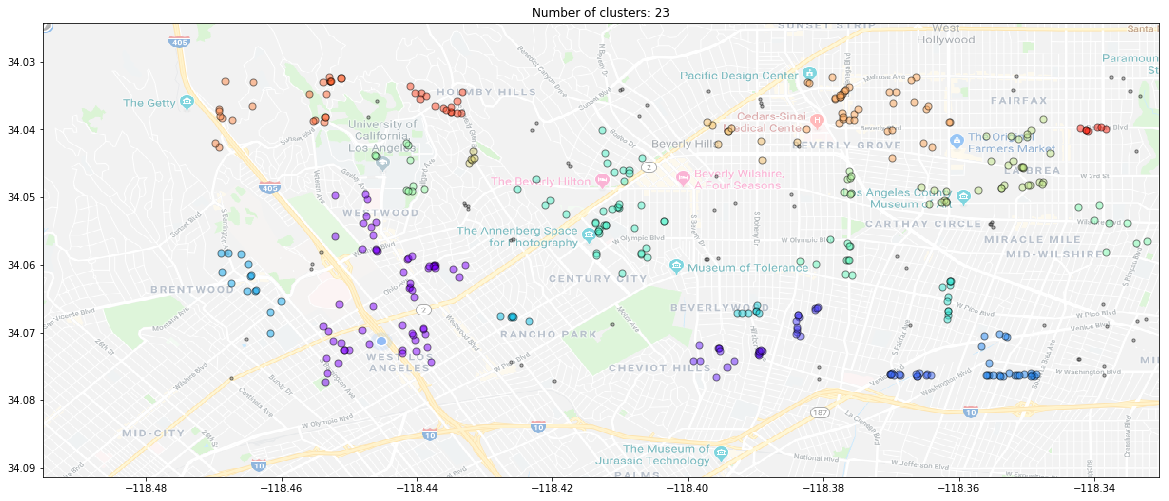

-------------------------------------
The number of noises: 64
-------------------------------------
Total number of Venues clustered: 373
-------------------------------------
The number of Venues in Cluster 0 is 60
The number of Venues in Cluster 1 is 19
The number of Venues in Cluster 2 is 13
The number of Venues in Cluster 3 is 14
The number of Venues in Cluster 4 is 23
The number of Venues in Cluster 5 is 14
The number of Venues in Cluster 6 is 5
The number of Venues in Cluster 7 is 7
The number of Venues in Cluster 8 is 11
The number of Venues in Cluster 9 is 40
The number of Venues in Cluster 10 is 11
The number of Venues in Cluster 11 is 8
The number of Venues in Cluster 12 is 10
The number of Venues in Cluster 13 is 7
The number of Venues in Cluster 14 is 33
The number of Venues in Cluster 15 is 5
The number of Venues in Cluster 16 is 9
The number of Venues in Cluster 17 is 36
The number of Venues in Cluster 18 is 10
The number of Venues in Cluster 19 is 16
The number of Venue

In [14]:
# get colors and plot all the points, color-coded by cluster (or gray if not in any cluster, aka noise)
fig, ax = plt.subplots(figsize=(20, 10))
colors_noise = plt.cm.rainbow(np.linspace(0, 1, len(unique_noise_labels)))

# for each cluster label and color, plot the cluster's points
for cluster_label, color in zip(unique_noise_labels, colors_noise):
    
    size = 50
    if cluster_label == -1: #make the noise (which is labeled -1) appear as smaller gray points
        color = 'gray'
        size = 10
    
    # plot the points that match the current cluster label
    x_coords = coords_noise[cluster_noise_labels==cluster_label][:,1]
    y_coords = coords_noise[cluster_noise_labels==cluster_label][:,0]
    plt.scatter(x=x_coords, y=y_coords, c=color, edgecolor='k', s=size, alpha=0.5)

plt.imshow(map_image, extent=[-118.495294, -118.330490, 34.091303, 34.024301], alpha=0.5)
ax.set_title('Number of clusters: {}'.format(num_noise_clusters))
plt.show()

# Check the number of noises
print('-------------------------------------')
print('The number of noises:',len(coords_noise[cluster_noise_labels==-1]))

# Check the number of Venues in each clusters
print('-------------------------------------')
print('Total number of Venues clustered:', len(coords_noise[cluster_noise_labels!=-1]))
print('-------------------------------------')
for cluster_label in unique_noise_labels:
  if cluster_label != -1:
    print('The number of Venues in Cluster', cluster_label ,'is',len(coords_noise[cluster_noise_labels==cluster_label]))

In [0]:
# second cluster ids
coords2_ids = coords_noise_ids[cluster_noise_labels!=-1]
coords2_noise_ids = coords_noise_ids[cluster_noise_labels==-1]

### Evaluation of DBSCAN

The silhouette coefficient evaluates how close a point is to the other points in its cluster in comparison with how close it is to the points in the next nearest cluster. A high silhouette coefficient indicates the points are well-clustered and a low value indicates an outlier.

In [16]:
# First Clustering
coefficient = metrics.silhouette_score(coords, cluster_labels)
print('First Clustering Silhouette coefficient: {:0.03f}'.format(coefficient))

# Second Clustering
coefficient_noise = metrics.silhouette_score(coords_noise, cluster_noise_labels)
print('Second Clustering Silhouette coefficient: {:0.03f}'.format(coefficient_noise))

First Clustering Silhouette coefficient: 0.249
Second Clustering Silhouette coefficient: 0.318


## Further Data Preparation

In [17]:
# Group labels and the noise
cluster1_max = max(list(cluster_labels[cluster_labels!=-1]))
labels = list(cluster_labels[cluster_labels!=-1]) + [lb + cluster1_max for lb in list(cluster_noise_labels[cluster_noise_labels!=-1])]
labels_noise = list(cluster_noise_labels[cluster_noise_labels==-1])
print(len(labels),len(labels_noise))

# Grouped ids and noise ids
ids = list(coords_ids[cluster_labels!=-1]) + list(coords_noise_ids[cluster_noise_labels!=-1])
ids_noise = list(coords_noise_ids[cluster_noise_labels==-1])
print(len(ids),len(ids_noise))

1578 64
1578 64


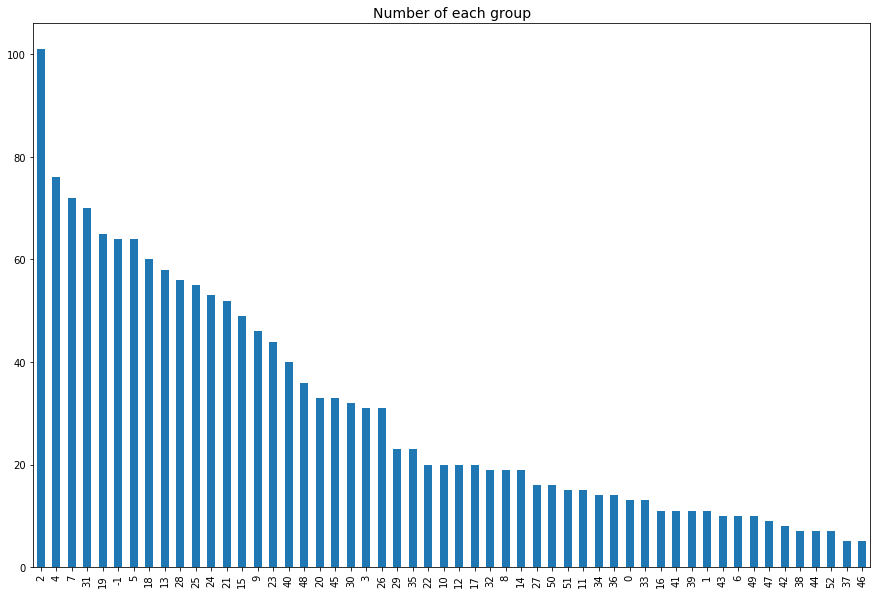

In [30]:
# Dataset for the spatial clustering groups
groups_dict = {'id' : ids + ids_noise, 'groups' : labels + labels_noise}
groups = pd.DataFrame.from_dict(groups_dict)
fig = plt.figure(figsize=(15, 10))
plt.title('Number of each group',fontsize=14)
groups.groups.value_counts().plot(kind='bar')
plt.show()

In [19]:
# Merge the groups dataset and the one-hot encoding data matrix
dat_new = pd.merge(groups,dat_onehot,how = 'left',on = 'id')
dat_new['lat'] = dat.lat
dat_new['lng'] = dat.lng
dat_new.head(2)

,id,groups,ATM,Accessories Store,Airport Terminal,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,"Bar, Pub & Club",Baseball Field,Basketball Court,Big Box Store,Bookstore,Boutique,Breakfast Spot,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Business Service,Cafeteria,Café,Camera Store,Candy Store,Car Wash,Cemetery,Chinese Restaurant,Chocolate Shop,...,Resort,Restaurant,Roof Deck,Salad Place,Sandwich Place,Scenic Lookout,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,Spa,Spiritual Center,Sporting Goods Shop,Steakhouse,Storage Facility,Street Food Gathering,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tea Room,Tennis Court,Thai Restaurant,Theater,Toy / Game Store,Track,Video Game Store,Video Store,Warehouse Store,Watch Shop,Weight Loss Center,Wine Shop,Wings Joint,Women's Store,Yoga Studio,lat,lng
0,4a417892f964a52055a51fe3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34.072743,-118.468628
1,46a7d6e0f964a5204c491fe3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34.073581,-118.468109


In [20]:
# Group rows by density clusters and by taking the mean of the frequency of occurrence of each category
dat_new_grouped = dat_new.groupby('groups').mean().reset_index()
print(dat_new_grouped.shape)
dat_new_grouped.head()

(54, 200)


,groups,ATM,Accessories Store,Airport Terminal,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,"Bar, Pub & Club",Baseball Field,Basketball Court,Big Box Store,Bookstore,Boutique,Breakfast Spot,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Business Service,Cafeteria,Café,Camera Store,Candy Store,Car Wash,Cemetery,Chinese Restaurant,Chocolate Shop,Churrascaria,...,Resort,Restaurant,Roof Deck,Salad Place,Sandwich Place,Scenic Lookout,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,Spa,Spiritual Center,Sporting Goods Shop,Steakhouse,Storage Facility,Street Food Gathering,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tea Room,Tennis Court,Thai Restaurant,Theater,Toy / Game Store,Track,Video Game Store,Video Store,Warehouse Store,Watch Shop,Weight Loss Center,Wine Shop,Wings Joint,Women's Store,Yoga Studio,lat,lng
0,-1,0.015625,0.000000,0.0,0.015625,0.0,0.000000,0.0,0.000000,0.015625,0.0,0.0,0.000000,0.0,0.0,0.000000,0.015625,0.015625,0.0,0.0,0.0,0.015625,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.015625,0.03125,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.015625,0.0,...,0.000000,0.046875,0.000000,0.0,0.031250,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.015625,0.0,0.0,0.0,0.000000,0.03125,0.0,0.015625,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.015625,34.034979,-118.402877
1,0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.076923,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.076923,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,34.073351,-118.467715
2,1,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.272727,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,34.073588,-118.454600
3,2,0.000000,0.000000,0.0,0.049505,0.0,0.009901,0.0,0.009901,0.000000,0.0,0.0,0.009901,0.0,0.0,0.019802,0.019802,0.059406,0.0,0.0,0.0,0.000000,0.049505,0.009901,0.0,0.0,0.0,0.009901,0.0,0.000000,0.00000,0.0,0.049505,0.0,0.009901,0.0,0.0,0.019802,0.009901,0.0,...,0.009901,0.029703,0.019802,0.0,0.009901,0.0,0.009901,0.0,0.0,0.009901,0.0,0.0,0.0,0.029703,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.019802,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009901,0.000000,34.073204,-118.377268
4,3,0.000000,0.032258,0.0,0.064516,0.0,0.000000,0.0,0.032258,0.000000,0.0,0.0,0.000000,0.0,0.0,0.032258,0.000000,0.064516,0.0,0.0,0.0,0.000000,0.064516,0.032258,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.064516,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.032258,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,34.072859,-118.395810


In [29]:
# Print top 5 groups along with the top 5 most common venues
num_top_venues = 5
for hood in [2,4,7,31,19]:
    print("----",hood,"----")
    temp = dat_new_grouped.drop(['lat','lng'],axis=1)[dat_new_grouped.drop(['lat','lng'],axis=1)['groups'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- 2 ----
                 venue  freq
0      Bar, Pub & Club  0.06
1       Clothing Store  0.06
2   Italian Restaurant  0.06
3  American Restaurant  0.05
4             Boutique  0.05


---- 4 ----
                      venue  freq
0            Clothing Store  0.11
1          Other Restaurant  0.11
2  Gym and Physics Training  0.04
3                  Boutique  0.04
4        Mexican Restaurant  0.03


---- 7 ----
                     venue  freq
0          Bar, Pub & Club  0.07
1              Coffee Shop  0.06
2              Pizza Place  0.06
3           Sandwich Place  0.06
4  New American Restaurant  0.04


---- 31 ----
                      venue  freq
0                     Hotel  0.09
1  Gym and Physics Training  0.06
2          Basketball Court  0.06
3               Bus Station  0.04
4                      Café  0.04


---- 19 ----
                       venue  freq
0           Other Restaurant  0.11
1   Mediterranean Restaurant  0.09
2              Grocery Store  0.05
3        A

### Store top venues into the dataframe



In [31]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

# create the new dataframe and display the top 5 venues for each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['groups']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
groups_venues_sorted = pd.DataFrame(columns=columns)
groups_venues_sorted['groups'] = dat_new_grouped.drop(['lat','lng'],axis=1)['groups']

for ind in np.arange(dat_new_grouped.drop(['lat','lng'],axis=1).shape[0]):
    groups_venues_sorted.iloc[ind, 1:] = return_most_common_venues(dat_new_grouped.drop(['lat','lng'],axis=1).iloc[ind, :], num_top_venues)

groups_venues_sorted.head()

,groups,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,-1,Gym and Physics Training,Landscape,Coffee Shop,Intersection,Restaurant,Clothing Store,Food Truck,Italian Restaurant,Taco Place,Historic Site
1,0,Gym and Physics Training,Hotel,Pool,Intersection,New American Restaurant,"Bar, Pub & Club",Landscape,Bus Station,Dog Run,Fast Food Restaurant
2,1,Café,Landscape,Hotel,Mexican Restaurant,Education,Coffee Shop,Movie Theater,Performing Arts Venue,Dog Run,Field
3,2,Italian Restaurant,"Bar, Pub & Club",Clothing Store,American Restaurant,Café,Boutique,Hotel,Restaurant,Cosmetics Shop,Coffee Shop
4,3,Italian Restaurant,"Bar, Pub & Club",Café,American Restaurant,Nightclub,Boutique,Cosmetics Shop,Furniture / Home Store,Mediterranean Restaurant,Clothing Store


## Part 2: K-Means Clustering evaluating the similarities among the groups

In [0]:
venues_map1 = folium.Map(location=[34.061872, -118.394760], zoom_start=10) # generate map centred around home

# add popular spots to the map as blue circle markers
for lat, lng, label in zip(dat.lat, dat.lng, dat.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6
        ).add_to(venues_map1)

# display map
venues_map1